# Titanic - Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np
import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleanup
First, We find out the Missing Data

In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Creating a working copy from the original csv data, Drop PassengerID and Cabin from the Training Set. Cabin has too much missing data and PassengerID is not useful in the Training Set. Drop Cabin from the Test Set since it is not necessary.

In [6]:
train = train_data.copy(deep=True)
test = test_data.copy(deep=True)

train = train.drop(['PassengerId', 'Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

There is two passenger with unknown port of embarkation. We assume they all embarked from Southampton because most people on Titanic embarked at Southampton.

In [7]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [8]:
(pd.concat([train,test])).groupby('Embarked').count()['Fare']

Embarked
C    270
Q    123
S    913
Name: Fare, dtype: int64

In [9]:
train['Embarked'] = train['Embarked'].fillna('S')

One of the "Fare" feature is unavailable in the test set,  We find the mean ticket price for the corresponding Pclass and fill it in.

In [10]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [11]:
mean_class_3 = np.nanmean(pd.concat([train[train['Pclass']==3]['Fare'],test[test['Pclass']==3]['Fare']]).values)
print ("Mean Ticket Price for Class 3 =", mean_class_3)

Mean Ticket Price for Class 3 = 13.3028887006


In [12]:
test['Fare'] = test['Fare'].fillna(mean_class_3)

In [13]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

### Dealing With Tickets
Group Tickets together, If tickets # are duplicated, Alone = 0.

In [14]:
pd.concat(e for _, e in train.groupby("Ticket") if len(e) > 1)[:10]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
257,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,S
504,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,S
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S
262,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,S
558,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,S
585,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,S
110,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,S
475,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,S
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,C
523,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,C


In [15]:
train['Alone'] = 1
train.loc[train.duplicated(subset='Ticket'),'Alone'] = 0
test['Alone'] = 1
test.loc[test.duplicated(subset='Ticket'),'Alone'] = 0

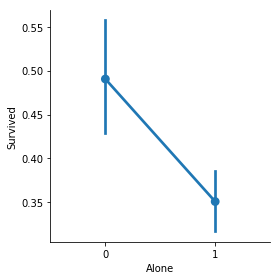

In [16]:
sns.factorplot(x="Alone", y="Survived", data=train)

In [17]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

### Extract Titles from Names
Adapted From https://www.kaggle.com/niklasdonges/end-to-end-project-with-python

In [18]:
data = [train, test]
titles = {"Mr", "Miss", "Mrs", "Master", "Rare"}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col','Don', 'Major', 'Dr', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Lady', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Countess', 'Mrs')

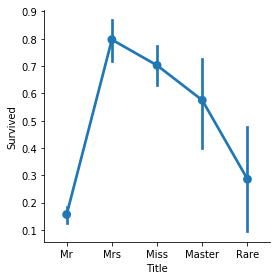

In [19]:
sns.factorplot(x="Title", y="Survived", data=train)

In [20]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

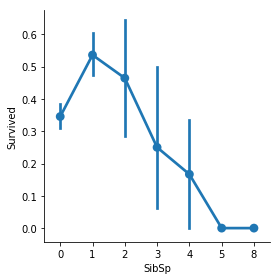

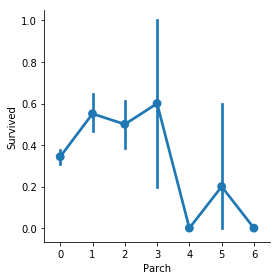

In [21]:
sns.factorplot(x="SibSp", y="Survived", data=train)
sns.factorplot(x="Parch", y="Survived", data=train)

### Create a FamilySize parameter, from "Parch" & "SibSp"

In [22]:
train['FamilySize'] = train["Parch"].values+train["SibSp"]

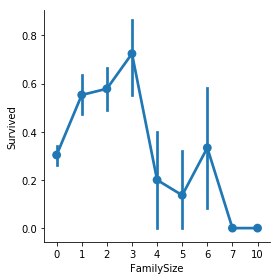

In [23]:
sns.factorplot(x='FamilySize', y="Survived", data=train)

### Categorical Variables to Dummy Variables

In [24]:
pd.concat([train,test]).groupby('Title').count()['Age']

Title
Master     53
Miss      213
Mr        581
Mrs       173
Rare       26
Name: Age, dtype: int64

In [25]:
pd.concat([train,test]).groupby('Sex').count()['Age']

Sex
female    388
male      658
Name: Age, dtype: int64

In [26]:
pd.concat([train,test]).groupby('Alone').count()['Age']

Alone
0    229
1    817
Name: Age, dtype: int64

In [27]:
pd.concat([train,test]).groupby('Embarked').count()['Age']

Embarked
C    212
Q     50
S    784
Name: Age, dtype: int64

In [28]:
pd.concat([train,test]).groupby('Pclass').count()['Age']

Pclass
1    284
2    261
3    501
Name: Age, dtype: int64

In [29]:
data = [train, test]
dummies = ['Pclass', 'Sex', 'Embarked', 'Alone', 'Title']
train = pd.concat([train, pd.get_dummies(train[dummies], columns=dummies)], axis=1)
test = pd.concat([test, pd.get_dummies(test[dummies], columns=dummies)], axis=1)

In [30]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'Title', 'FamilySize', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Alone_0', 'Alone_1', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

### Dealing with Age

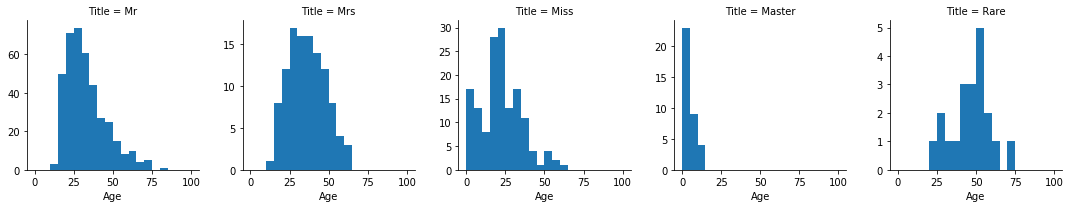

In [31]:
grid = sns.FacetGrid(train, col='Title', sharey=False)
grid.map(plt.hist, 'Age', bins=range(0,105,5))
plt.show()

## Title and Age has strong relationship
Fill the missing age with a random value with the normal model created from the mean and standard deviation given a particular title

In [32]:
data_summary = pd.concat([train,test])
print('mean', data_summary.loc[data_summary['Age']>0,['Title', 'Age']].groupby(['Title']).mean())
print()
print('std', data_summary.loc[data_summary['Age']>0,['Title', 'Age']].groupby(['Title']).std())
means = data_summary.loc[data_summary['Age']>0,['Title', 'Age']].groupby(['Title']).mean()
stds = data_summary.loc[data_summary['Age']>0,['Title', 'Age']].groupby(['Title']).std()

mean               Age
Title            
Master   5.482642
Miss    21.824366
Mr      32.252151
Mrs     36.959538
Rare    45.538462

std               Age
Title            
Master   4.161554
Miss    12.171431
Mr      12.422089
Mrs     12.858062
Rare    11.261370


In [33]:
train.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Embarked          0
Alone             0
Title             0
FamilySize        0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Sex_female        0
Sex_male          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Alone_0           0
Alone_1           0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
dtype: int64

In [34]:
test.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             0
Embarked         0
Alone            0
Title            0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Alone_0          0
Alone_1          0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Rare       0
dtype: int64

In [35]:
np.random.seed()
train['Age'] = train['Age'].fillna(-1)
test['Age'] = test['Age'].fillna(-1)
data = [train,test]
for data_i in data:
    ages_i = []
    for index, row in data_i[data_i['Age']< 0].iterrows():
        mu = means.loc[means.index==row['Title'],'Age'].values
        std = stds.loc[stds.index==row['Title'],'Age'].values
        ages_i.append(np.random.normal(mu,std)[0])
    data_i.loc[data_i['Age']< 0,'Age'] = ages_i

In [36]:
test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Alone           0
Title           0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Alone_0         0
Alone_1         0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
dtype: int64

In [37]:
train.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Alone           0
Title           0
FamilySize      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Alone_0         0
Alone_1         0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
dtype: int64

### Age Binning Method on Kaggle
https://www.kaggle.com/liyenhsu/titanic-neural-network

In [38]:
bin_age = [0, 4, 12, 18, 30, 50, 65, 100]
label_age = [0, 1, 2, 3, 4, 5, 6]
for data_i in data:
    data_i['Age_bin'] = pd.cut(data_i.Age,bin_age,labels=label_age)
train = pd.concat([train, pd.get_dummies(train['Age_bin'], columns=['Age_bin'], prefix='Age_bin', prefix_sep='_')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Age_bin'], columns=['Age_bin'], prefix='Age_bin', prefix_sep='_')], axis=1)

## Fare Data
Fare was actually charged for the whole group of passengers on the same ticket. Create new param "Fareppl"

In [39]:
ppl_on_ticket = []
for index, row in train_data.iterrows():
    ppl_on_ticket.append(1.*sum(train_data["Ticket"]==row['Ticket']))
fare_per_ppl = train_data['Fare'].values/np.array(ppl_on_ticket)
train_data['Fareppl'] = fare_per_ppl

In [40]:
print(train_data.corr())

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   
Fareppl        -0.002230  0.254824 -0.655559  0.227631 -0.012298  0.060240   

                 Fare   Fareppl  
PassengerId  0.012658 -0.002230  
Survived     0.257307  0.254824  
Pclass      -0.549500 -0.655559  
Age          0.096067  0.227631  
SibSp        0.159651 -0.012298  
Parch        0.216225  0.060240  
Fare         1.000000  0.839037  
Fareppl      0.839037  1.

In [41]:
train['Fareppl'] = train_data['Fareppl']

In [42]:
ppl_on_ticket = []
for index, row in test_data.iterrows():
    ppl_on_ticket.append(1.*sum(test_data["Ticket"]==row['Ticket']))
test['Fareppl'] = test['Fare'].values/np.array(ppl_on_ticket)

## Building Models

In [43]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'Title', 'FamilySize', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Alone_0', 'Alone_1', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Age_bin', 'Age_bin_0',
       'Age_bin_1', 'Age_bin_2', 'Age_bin_3', 'Age_bin_4', 'Age_bin_5',
       'Age_bin_6', 'Fareppl'],
      dtype='object')

In [44]:
enabled_features = ['SibSp', 'Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
                   'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Alone_0', 'Alone_1',
                   'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 
                   'Age_bin_0', 'Age_bin_1', 'Age_bin_2', 'Age_bin_3', 'Age_bin_4', 'Age_bin_5', 'Age_bin_6', 
                   'Fareppl']

X_all = train[enabled_features]
y_all = train['Survived']

X_test = test[enabled_features]
ppl_id = test_data['PassengerId']

### Tuning
Create a list of random learning rate and random hidden layer sizes.

In [45]:
# Random learning rate from .0001 to 1
def rand_learning_rate(n_max=1000):
    return list(10.**np.random.uniform(-3,0,n_max))
# Hidden layers: generates list of n_max layer with each integer being the number of neurons
# The ith element represents the number of neurons in the ith hidden layer.
def rand_hidden_layer_sizes(n_l_min,n_l_max,n_a_min,n_a_max,n_max=1000):
    n_l = np.random.randint(n_l_min,n_l_max,n_max)
    list_hl = []
    for nl_i in n_l:
        list_hl.append(tuple(np.random.randint(n_a_min,n_a_max,nl_i)))
    return list_hl

In [69]:
# NN hyper parameters to test
param_dist_nn = {"activation": ["relu"],
                 "solver": ["adam"],
                 "learning_rate_init": rand_learning_rate(),
                 "hidden_layer_sizes": rand_hidden_layer_sizes(2,15,5,20),
                 "alpha": [0.00001,0.000006,0.000003,0.000001],
                 "max_iter":[1000],
                }

# Report Best Score
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
from sklearn.model_selection import RandomizedSearchCV

def model_random_search(cl, param_dist, n_iter, X, y):
    random_search = RandomizedSearchCV(cl,param_distributions=param_dist,n_iter=n_iter,cv=4)
    random_search = random_search.fit(X, y)
    report(random_search.cv_results_, n_top=3)
    return random_search

from sklearn.neural_network import MLPClassifier
# Execute random search 30 times
random_search_nn = model_random_search(MLPClassifier(batch_size=256), param_dist_nn, 30, X_all, y_all)

Model with rank: 1
Mean validation score: 0.824 (std: 0.033)
Parameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.011587336513123977, 'hidden_layer_sizes': (14, 10, 17, 17, 14), 'alpha': 3e-06, 'activation': 'relu'}

Model with rank: 2
Mean validation score: 0.816 (std: 0.019)
Parameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.003889267997305572, 'hidden_layer_sizes': (8, 7, 7), 'alpha': 1e-06, 'activation': 'relu'}

Model with rank: 3
Mean validation score: 0.815 (std: 0.035)
Parameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.010646261080598874, 'hidden_layer_sizes': (19, 6, 15, 17, 7, 11, 9, 13, 13, 6), 'alpha': 1e-06, 'activation': 'relu'}



In [76]:
# Wrap-up function for training, see http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from sklearn.metrics import recall_score, average_precision_score, precision_score, f1_score

def apply_cl(cl, x_test, ppl_id):
    out_test_data = cl.predict(x_test)
    answer = np.array([ppl_id,out_test_data]).T
    return answer

def train_cl_param(classifier, X, y, param):
    cl = classifier(**param)
    cl.fit(X,y)
    score = cl.score(X,y)
    r = recall_score(y, cl.predict(X))
    p = average_precision_score(y, cl.predict(X))
    f = f1_score(y, cl.predict(X))
    print('score', score, 'avg precision =', p, 'recall =', r, 'f-score =', f)
    return cl

# Utility functions for writing prediction
def write_result(cl, file_out, X_test, ppl_id):
    an = apply_cl(cl, X_test, ppl_id)
    np.savetxt(file_out, apply_cl(cl, X_test, ppl_id), header='PassengerId,Survived', delimiter=',', fmt='%i', comments='')

In [77]:
par = {'learning_rate_init': 0.015880338509101498, 
       'alpha': 1e-05, 
       'activation': 'relu', 
       'solver': 'adam',
       'hidden_layer_sizes': (7, 19, 18, 12, 7),
       'batch_size':256
       }
# Train using generated learning rate
nn = train_cl_param(MLPClassifier, X_all, y_all, par)
write_result(nn, 'submission.csv', X_test, ppl_id)

score 0.835016835017 avg precision = 0.700218559868 recall = 0.760233918129 f-score = 0.779610194903
